In [116]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pywt 
import sklearn as sk

folder = [f for f in os.listdir('yalefull')]



L=np.array([[0 for x in range(32256)]]).T

lev=4
w='db1'


for fold in folder:
    images_name=[f for f in os.listdir(f'yalefull/{fold}')]
    np.random.shuffle(images_name)

    for n in range(0,50):
        A=imread(f'yalefull/{fold}/{images_name[n]}')
        if n==3 and fold == folder[0]:
            sample=A
            
        coeffs=pywt.wavedec2(A, wavelet=w, level=lev)
        coeff_arr, coeffs_slices=pywt.coeffs_to_array(coeffs)
        Csort=np.sort(np.abs(coeff_arr.reshape(-1)))

        threshold=Csort[int(np.floor((1-0.10)* len(Csort)))]
        ind=np.abs(coeff_arr)> threshold
        Cfilt=coeff_arr * ind

        coeffs_filt=pywt.array_to_coeffs(Cfilt, coeffs_slices, output_format='wavedec2')
        reconstructed=pywt.waverec2(coeffs_filt, wavelet=w)

        x,y=reconstructed.shape
        reconstructed=np.array([reconstructed.ravel()]).T
    
        L=np.hstack((L,reconstructed))

L=L[:,1:]



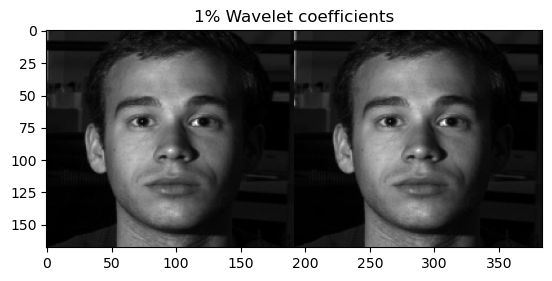

In [117]:
placeholder=np.zeros((x, y*2))
placeholder[:,:y]=sample
placeholder[:,y:]=L[:,3].reshape(x,y)

plt.imshow(placeholder, cmap='gray')
plt.title('1% Wavelet coefficients')
plt.show()

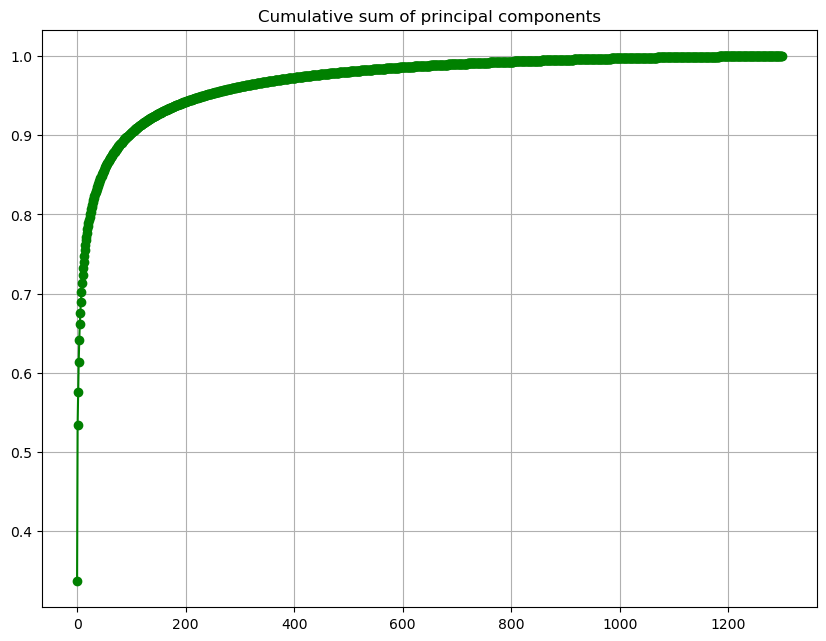

In [118]:
pca=sk.decomposition.PCA().fit(L[:,1:])
X=np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10,7.5))
plt.xlabel('')
plt.plot(X, marker='o', linestyle='-', color='green')
plt.grid(True)
plt.title('Cumulative sum of principal components')

plt.show()

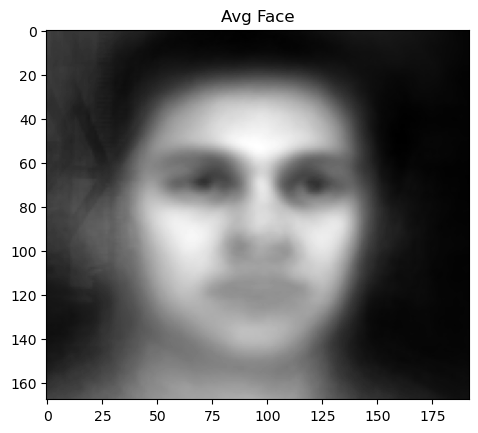

In [119]:
avg_face=[]

for row in range(len(L)):
    avg=np.mean(L[row,1:])
    avg_face.append(avg)
avg_face=np.array([avg_face]).T
plt.title('Avg Face')
plt.imshow(avg_face.reshape(x,y), cmap='gray')


(2, 1300)


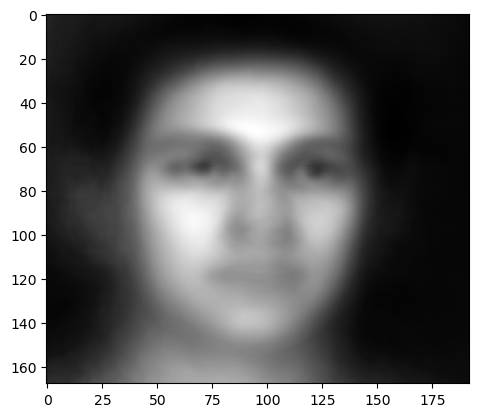

In [120]:
pca=sk.decomposition.PCA(n_components=2).fit(L)
print(pca.components_.shape)
X_pca=pca.transform(L)
x,y=168,192

plt.imshow(X_pca[:,0].reshape(x,y), cmap='gray')


Text(0, 0.5, 'Silhouette score')

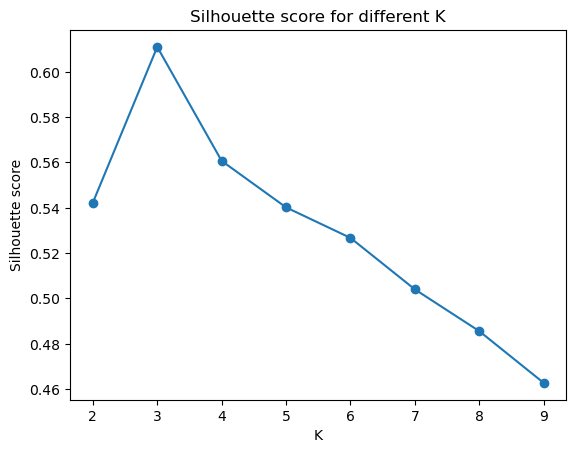

In [121]:
sil_score=[]
for n in range(2,10):
    kmeans=sk.cluster.KMeans(n_clusters=n)
    sil_score.append(sk.metrics.silhouette_score(X_pca, kmeans.fit_predict(X_pca)))

plt.title('Silhouette score for different K')
plt.plot(np.arange(2,len(sil_score)+2),sil_score, marker='o')

plt.xlabel('K')
plt.ylabel('Silhouette score')


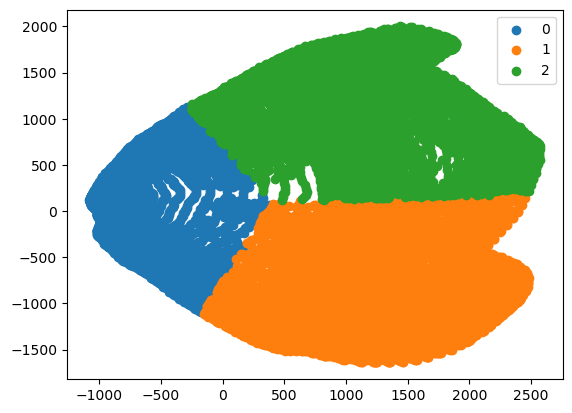

In [122]:
import pandas as pd
kmeans=sk.cluster.KMeans(n_clusters=3).fit(X_pca)


labels=kmeans.labels_
df=pd.DataFrame(X_pca, columns=['PCA1','PCA2'])
df['labels']=labels

for x in set(labels):
    plt.scatter(df.iloc[:,0][df['labels'] == x], df.iloc[:,1][df['labels'] == x], label=x)
plt.legend()
plt.show()

Text(0.5, 1.0, 'PCA grouped pixel')

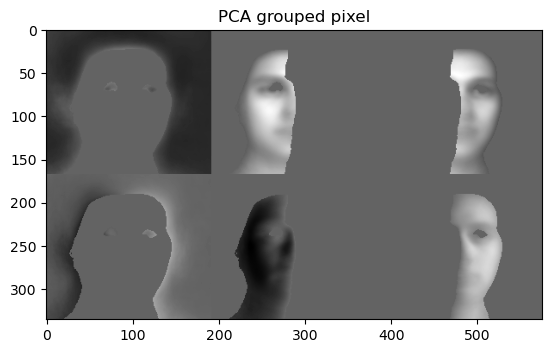

In [123]:

def fill_parts(df,target,pca):
    parts=[[]]
    i=0
    #test=(df.iloc[:,0][df['labels'] == target].to_numpy() + df.iloc[:,1][df['labels'] == target].to_numpy())/2


    i_list=df.iloc[:,pca][df['labels'] == target].index

    #transforming=df.iloc[:,0].to_numpy().reshape((168,192))
    i=0
    matrix=[]
    n=len(df.iloc[:,pca])
    for k,row in enumerate(df.iloc[:,pca]):
        if i == len(i_list):
            while k < n:
                matrix.append(0)
                k+=1
            break
        if k == i_list[i]:
            matrix.append(df.iloc[:,pca][i_list[i]])
            i+=1 
        else:
            matrix.append(0)
        
    matrix=np.array(matrix).reshape((168,192))

    return matrix


placeholder=np.zeros((168*2,192*3))
x,y=168,192
row,columns=2,3
for iy_ind,iy in enumerate(range(0,x*row,x)):
    for ix_ind,ix in enumerate(range(0,y*columns,y)):
        placeholder[iy:iy+x,ix:ix+y]=fill_parts(df,ix_ind,iy_ind)
        i+=1

plt.imshow(placeholder, cmap='gray')
plt.title('PCA grouped pixel')


#print(df.iloc[:,0][df['labels'] == 0].shape)

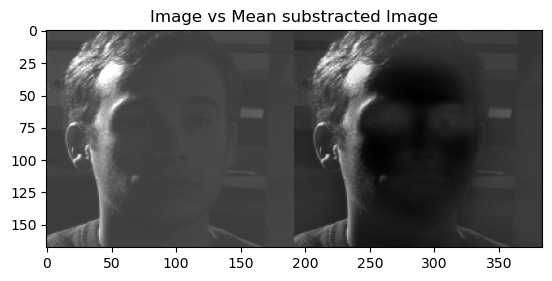

In [124]:

sample=np.copy(L[:,2])

for x in range(L.shape[1]):
    L[:,x]=L[:,x]-avg_face.ravel()

placeholder=np.zeros((168, 192*2))
placeholder[:, :192]=sample.reshape(168,192)
placeholder[:, 192:]=L[:,2].reshape(168,192)

plt.title('Image vs Mean substracted Image')
plt.imshow(placeholder, cmap='gray')


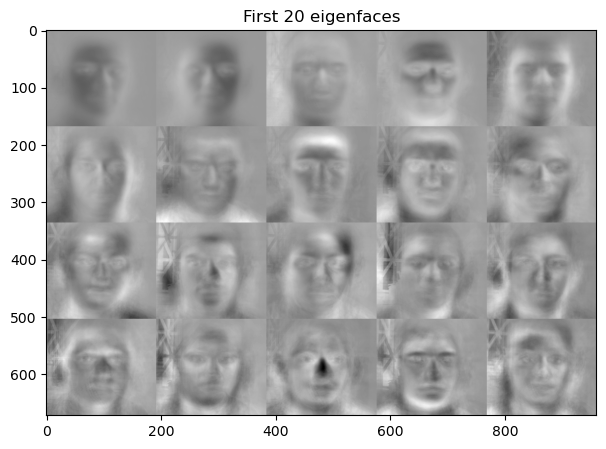

In [125]:

folder = [f for f in os.listdir('yalefull')]


L=np.array([[0 for x in range(32256)]]).T


for fold in folder:
    images_name=[f for f in os.listdir(f'yalefull/{fold}')]
    np.random.shuffle(images_name)

    for n in range(0,50):
        A=imread(f'yalefull/{fold}/{images_name[n]}')

        A=np.array([A.ravel()]).T
        L=np.hstack((L,A))
L=L[:,1:]
x,y=168,192

avg_face=[]
for row in range(len(L)):
    avg=np.mean(L[row,:])
    avg_face.append(avg)
avg_face=np.array([avg_face]).T



for k in range(L.shape[1]):
    L[:,k]=L[:,k]-avg_face.ravel()


U, S, Vt= np.linalg.svd(L,full_matrices=0)

row,columns=4,5

eigenfaces=np.zeros((x*row, y*columns))
i=0

for iy in range(0,x*row,x):
    for ix in range(0,y*columns,y):
        eigenfaces[iy:iy+x,ix:ix+y]=U[:,i].reshape(x,y)
        i+=1

plt.figure(figsize=(10,5))
plt.imshow(eigenfaces, cmap='gray')
plt.title(f'First {row*columns} eigenfaces')
plt.show()

Text(0.5, 1.0, 'Using the truncated identity matrix to approximate dog image')

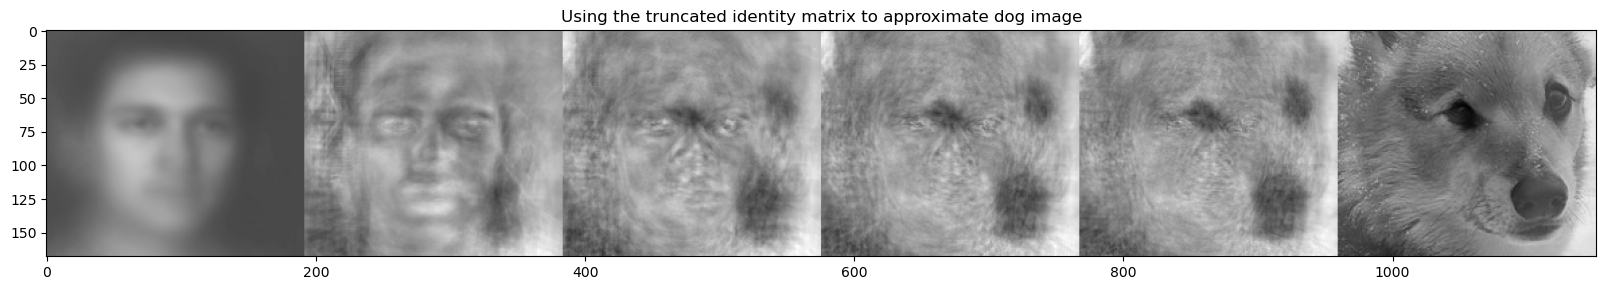

In [126]:
r=1

dog=imread('dog.jpg')
dog=np.mean(dog,-1)


placeholder=np.zeros((x,y))
placeholder=dog[x*1:x*2,y*2+80:y*3+80]
entire_fig=np.zeros((x, y*6))


dog=np.array([placeholder.ravel()]).T-avg_face

iy=0
for r in (1,50,300,700,1300):
  
    I=avg_face+np.array([U[:,:r] @ (U[:, :r].T @ dog)])
    I=I.reshape(x,y)

    entire_fig[:,iy:iy+y]=I
    iy+=y

entire_fig[:,iy:]=dog.reshape(x,y)

plt.figure(figsize=(20,10))
plt.imshow(entire_fig, cmap='gray')
plt.title('Using the truncated identity matrix to approximate dog image')

#reconstructed=np.array([avg_face.ravel()+I.ravel()])

#plt.imshow(reconstructed.reshape(244,320), cmap='gray')